
# Stereo Vision



Storageroom

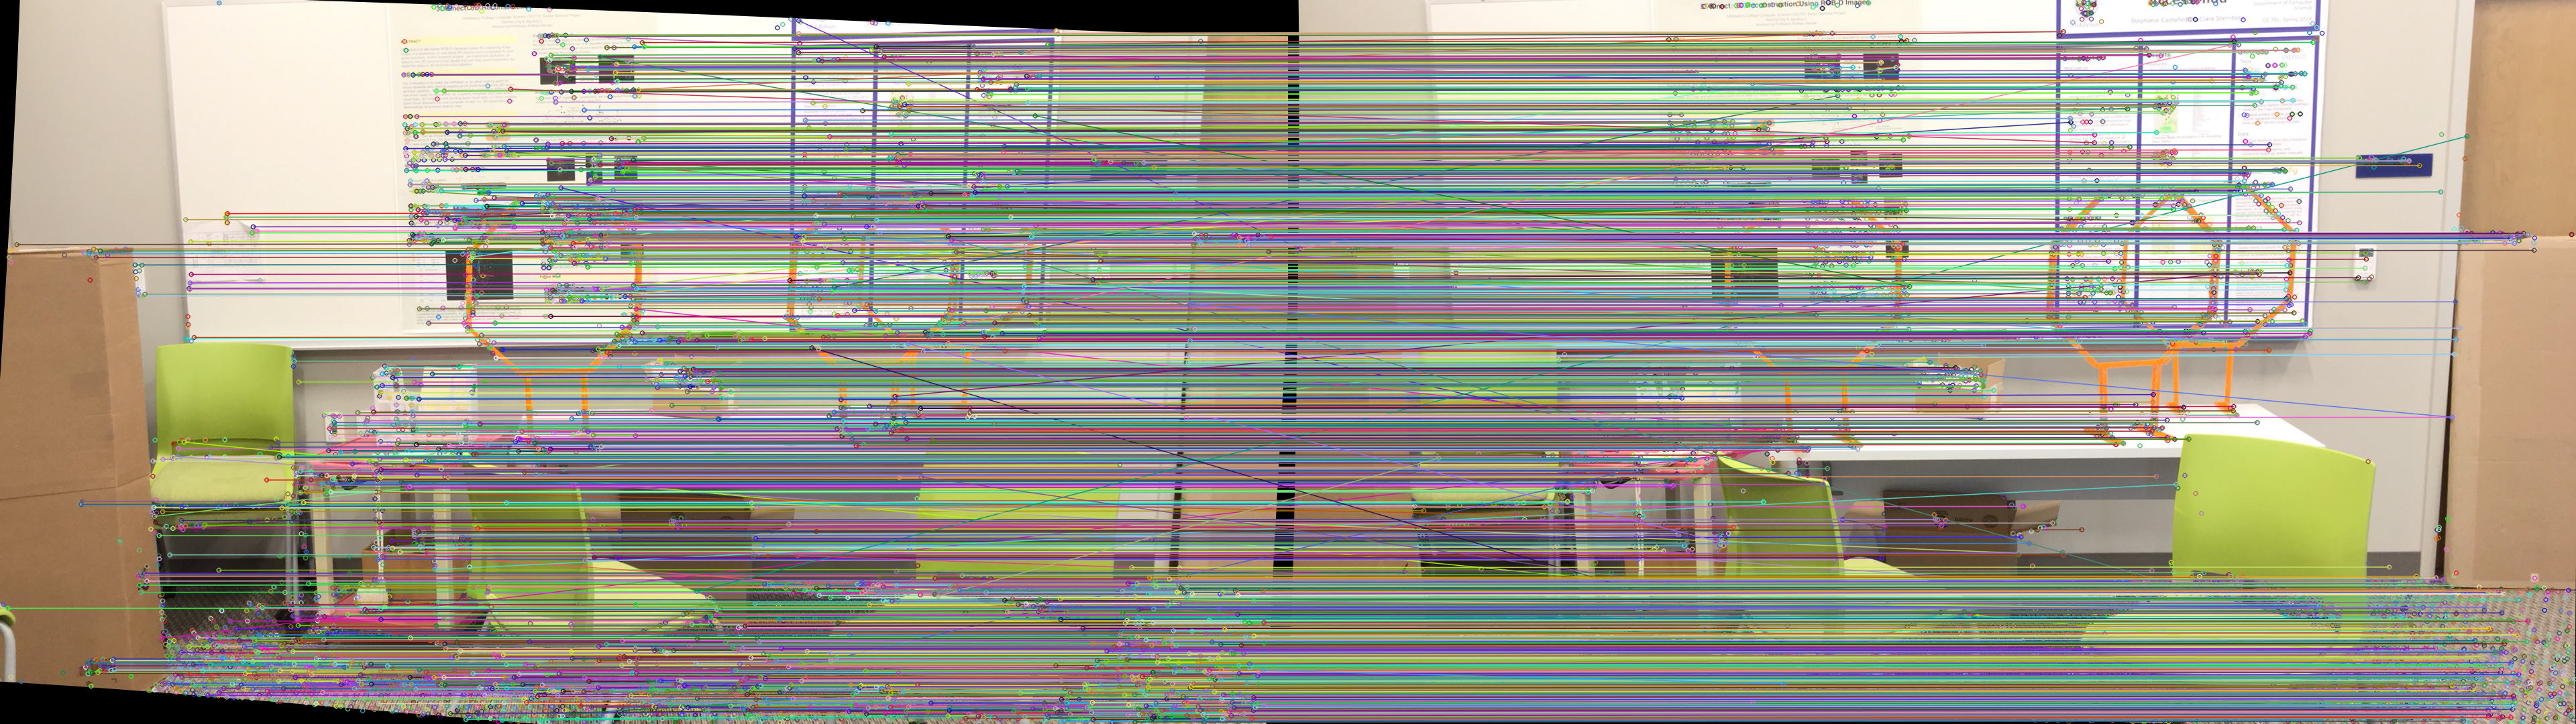

Fundamental Matrix:
[[ 3.02348122e-09 -4.45848227e-07  8.05256229e-03]
 [ 5.30268104e-07  1.34387280e-07  2.04999483e-01]
 [-8.11151133e-03 -2.05576414e-01  1.00000000e+00]]

Essential Matrix:
[[ 9.17610603e-03 -1.35312585e+00  1.36123143e+01]
 [ 1.60933573e+00  4.07858306e-01  3.58001912e+02]
 [-1.36269343e+01 -3.58635197e+02  7.18403928e-01]]

Rotation Matrix 1:
[[-0.99708054  0.07591595  0.00819603]
 [ 0.07590286  0.99711341 -0.0018959 ]
 [ 0.0083163   0.00126826  0.99996461]]

Rotation Matrix 2:
[[-9.99999758e-01 -1.57848756e-05  6.95028920e-04]
 [ 1.68676495e-05 -9.99998786e-01  1.55790495e-03]
 [-6.95003485e-04 -1.55791630e-03 -9.99998545e-01]]

Translation Vector:
[[ 0.99927093]
 [-0.03798765]
 [-0.00381344]]


In [ ]:
# Feature detection and matching
import cv2
import numpy as np

# Load images
image1 = cv2.imread('/content/drive/MyDrive/Bhavana/Perception/problem2_dataset/storageroom/im0.png')
image2 = cv2.imread('/content/drive/MyDrive/Bhavana/Perception/problem2_dataset/storageroom/im1.png')

# Load calibration parameters
calib_data = {
    'cam0': np.array([[1742.11, 0, 804.90], [0, 1742.11, 541.22], [0, 0, 1]]),
    'cam1': np.array([[1742.11, 0, 804.90], [0, 1742.11, 541.22], [0, 0, 1]]),
    'doffs': 0,
    'baseline': 221.76,
    'width': 1920,
    'height': 1080,
    'ndisp': 100,
    'vmin': 29,
    'vmax': 61
}

# Extract camera matrices
K1 = calib_data['cam0']
K2 = calib_data['cam1']

# Example: Use SIFT feature detector and Brute Force matcher
sift = cv2.SIFT_create()
keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

# Apply ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Extract matched keypoints
matched_keypoints1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
matched_keypoints2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Draw matches
match_img = cv2.drawMatches(image1, keypoints1, image2, keypoints2, good_matches, None)

# Display matches
cv2_imshow(match_img)

# Compute Fundamental matrix
F, mask = cv2.findFundamentalMat(matched_keypoints1, matched_keypoints2, cv2.FM_RANSAC, 0.1, 0.99)

# Compute Essential matrix from Fundamental matrix and calibration parameters
E = np.dot(np.dot(K2.T, F), K1)

# Decompose Essential matrix into rotation and translation matrices
U, S, Vt = np.linalg.svd(E)
W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
R1 = np.dot(np.dot(U, W), Vt)
R2 = np.dot(np.dot(U, W.T), Vt)
t = U[:, 2].reshape(-1, 1)

# Display results
print("Fundamental Matrix:")
print(F)
print("\nEssential Matrix:")
print(E)
print("\nRotation Matrix 1:")
print(R1)
print("\nRotation Matrix 2:")
print(R2)
print("\nTranslation Vector:")
print(t)


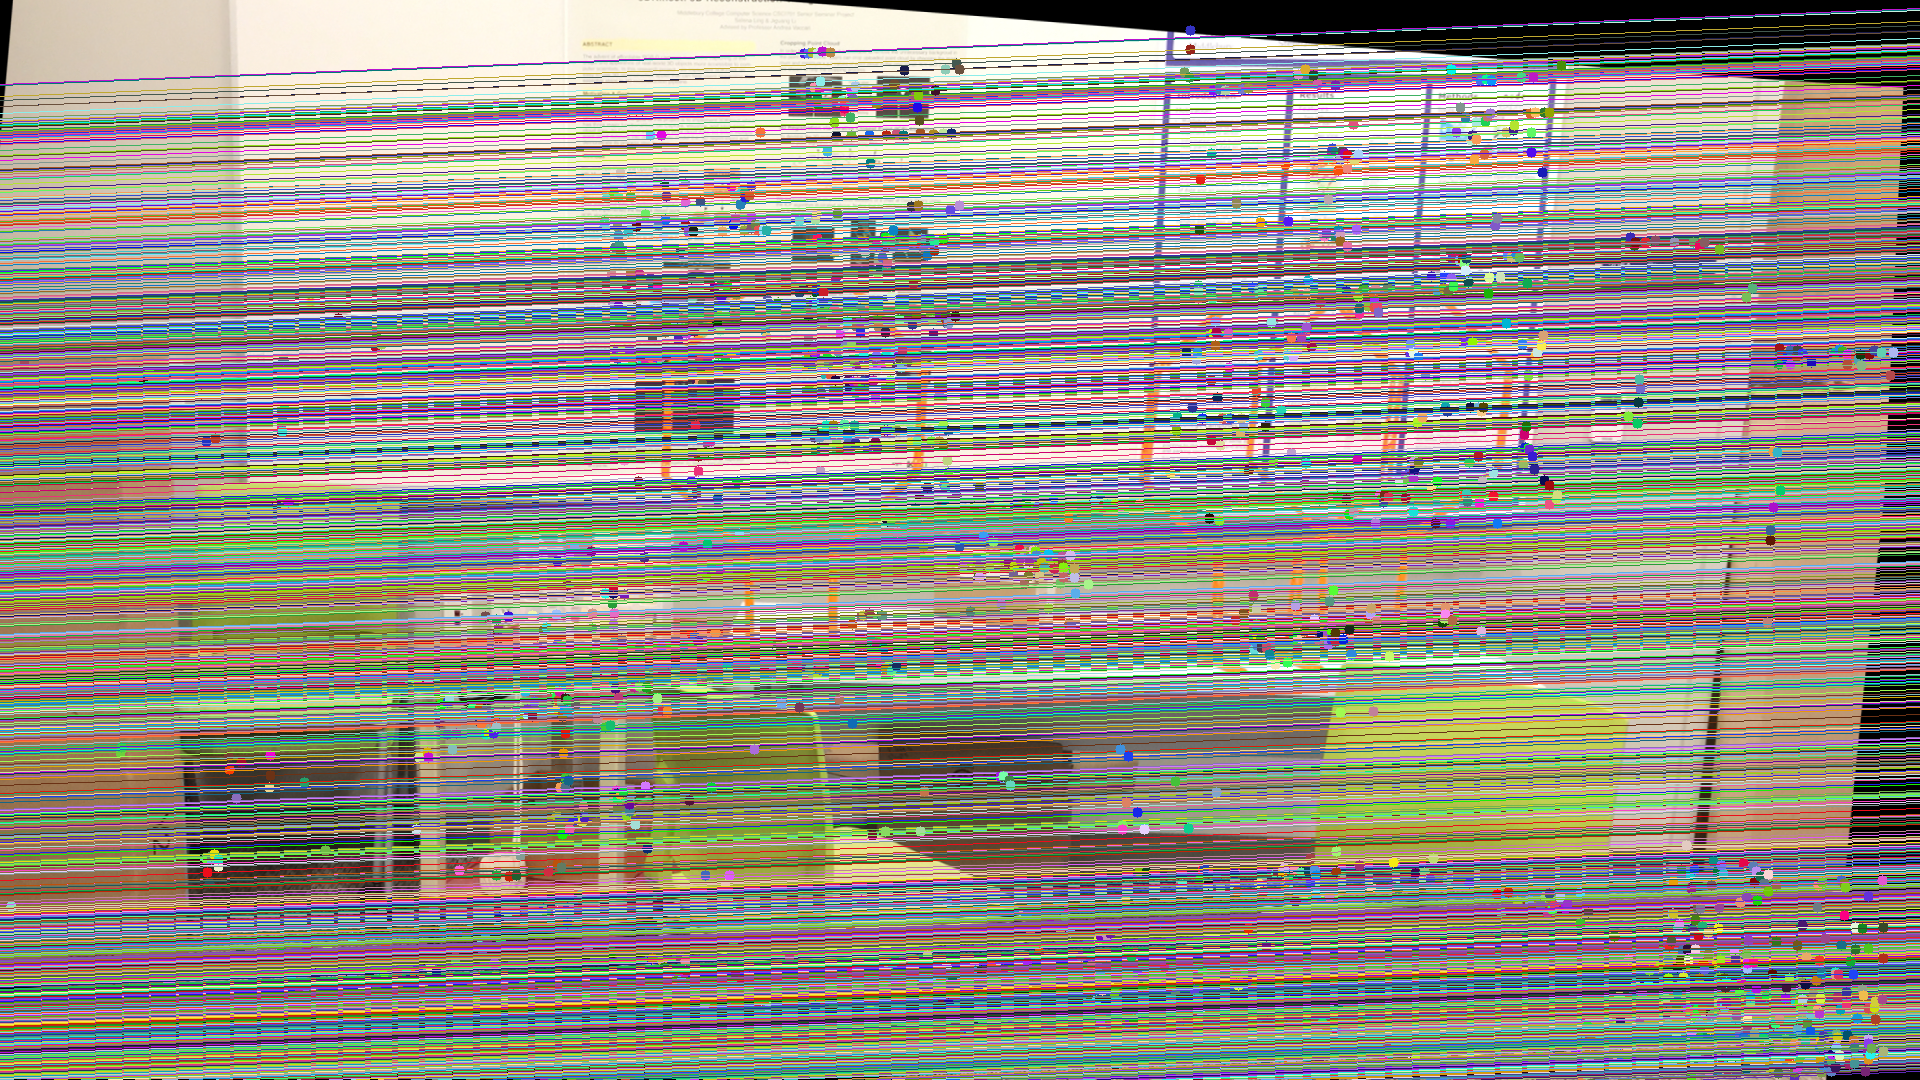

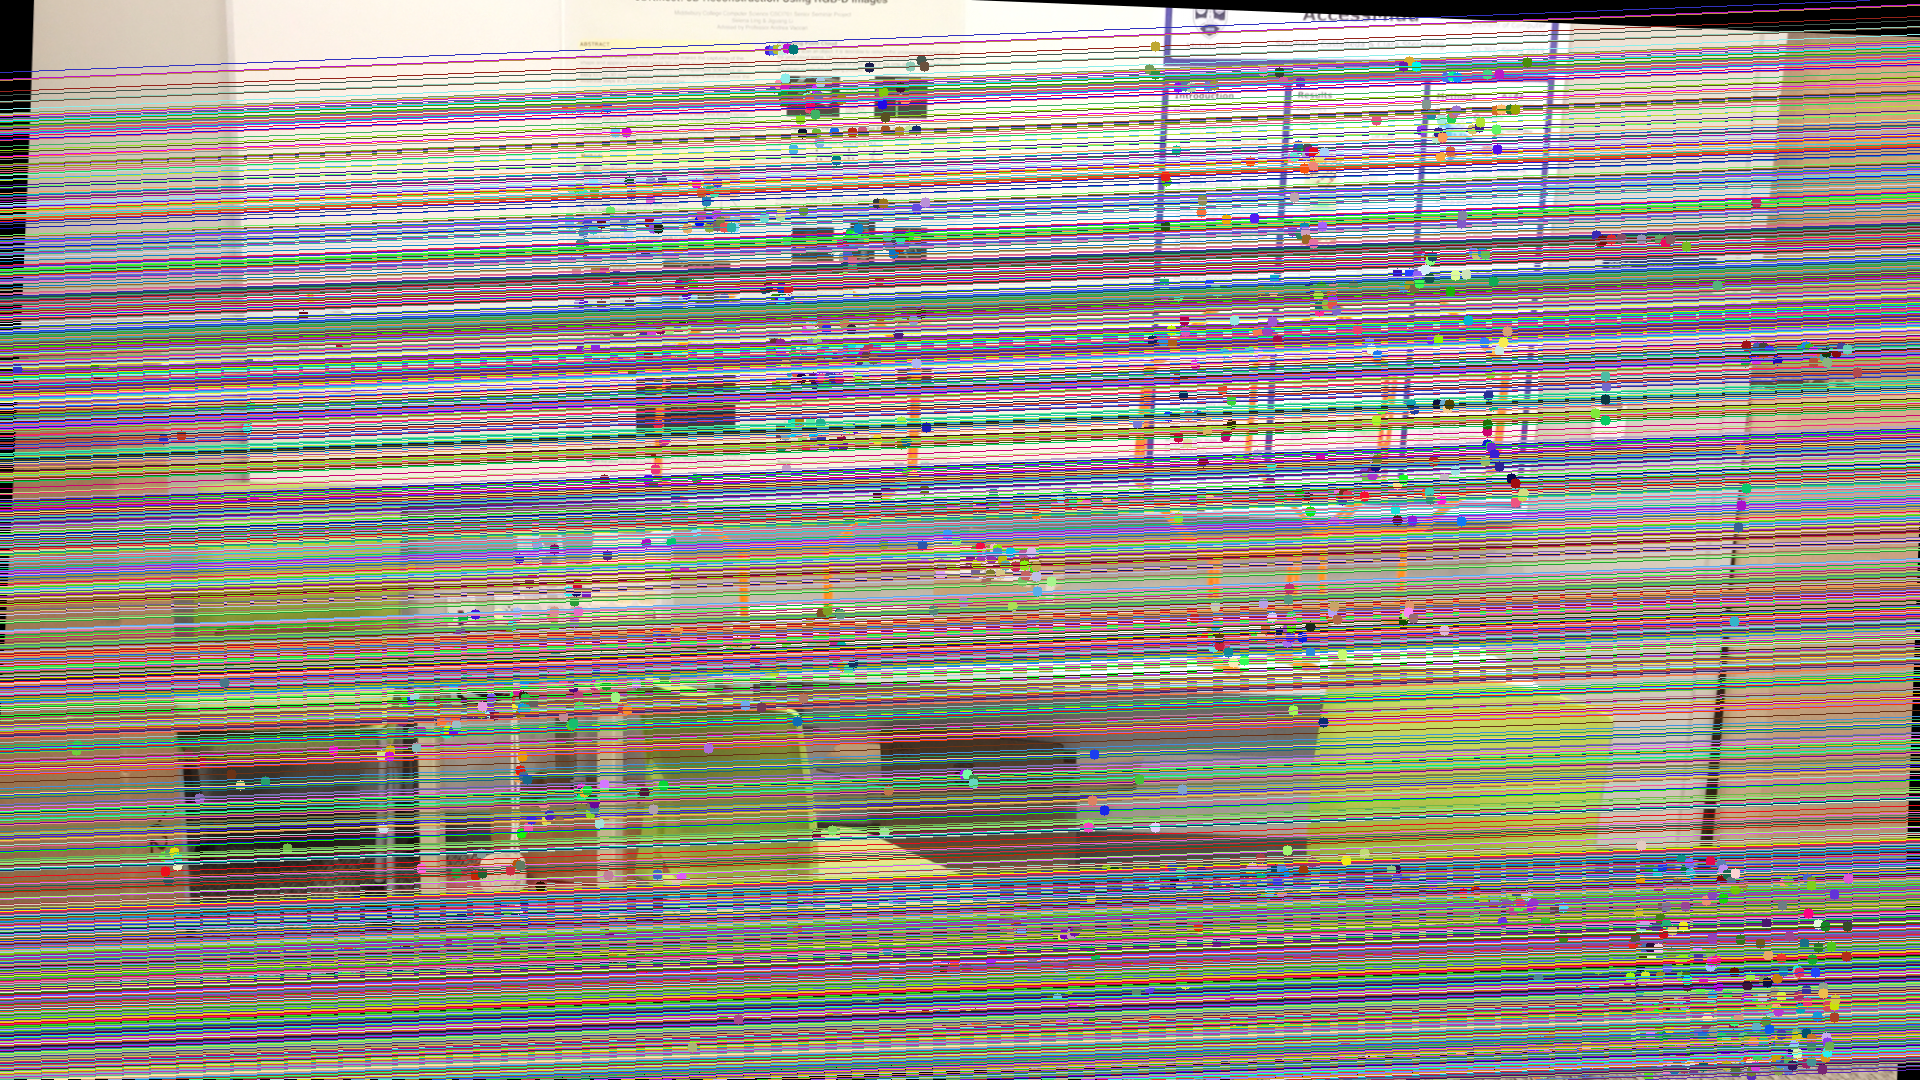

Rectification Homography Matrix 1 (H1):
[[-2.05678198e-01  9.37121003e-03  2.74642923e+00]
 [-8.09181323e-03 -2.05572215e-01  8.62742527e+00]
 [-5.28912014e-07 -1.17117040e-07 -2.04736114e-01]]

Rectification Homography Matrix 2 (H2):
[[ 1.00137779e+00 -3.80574862e-02  1.92283634e+01]
 [ 3.91585080e-02  9.99233710e-01 -3.71783712e+01]
 [ 2.18667095e-06 -8.31046988e-08  9.97945672e-01]]


In [ ]:
# Rectification
# Compute rectification homography matrices
retval, H1, H2 = cv2.stereoRectifyUncalibrated(matched_keypoints1, matched_keypoints2, F, (calib_data['width'], calib_data['height']))

# Apply rectification to images
image1_rectified = cv2.warpPerspective(image1, H1, (calib_data['width'], calib_data['height']))
image2_rectified = cv2.warpPerspective(image2, H2, (calib_data['width'], calib_data['height']))

# Visualize epipolar lines and feature points on rectified images
lines1 = cv2.computeCorrespondEpilines(matched_keypoints2.reshape(-1, 1, 2), 2, F).reshape(-1, 3)
lines2 = cv2.computeCorrespondEpilines(matched_keypoints1.reshape(-1, 1, 2), 1, F).reshape(-1, 3)

for line1, line2, (x1, y1), (x2, y2) in zip(lines1, lines2, matched_keypoints1[:, 0], matched_keypoints2[:, 0]):
    color = tuple(np.random.randint(0, 255, 3).tolist())
    x0, y0 = map(int, [0, -line1[2] / line1[1]])
    image1_rectified = cv2.line(image1_rectified, (0, -int(line1[2] / line1[1])), (calib_data['width'], -int((line1[2] + line1[0] * calib_data['width']) / line1[1])), color, 1)
    image1_rectified = cv2.circle(image1_rectified, (int(x1), int(y1)), 5, color, -1)
    image2_rectified = cv2.line(image2_rectified, (0, -int(line2[2] / line2[1])), (calib_data['width'], -int((line2[2] + line2[0] * calib_data['width']) / line2[1])), color, 1)
    image2_rectified = cv2.circle(image2_rectified, (int(x2), int(y2)), 5, color, -1)

# Display rectified images
cv2_imshow(image1_rectified)
cv2_imshow(image2_rectified)

# Print rectification homography matrices
print("Rectification Homography Matrix 1 (H1):")
print(H1)
print("\nRectification Homography Matrix 2 (H2):")
print(H2)


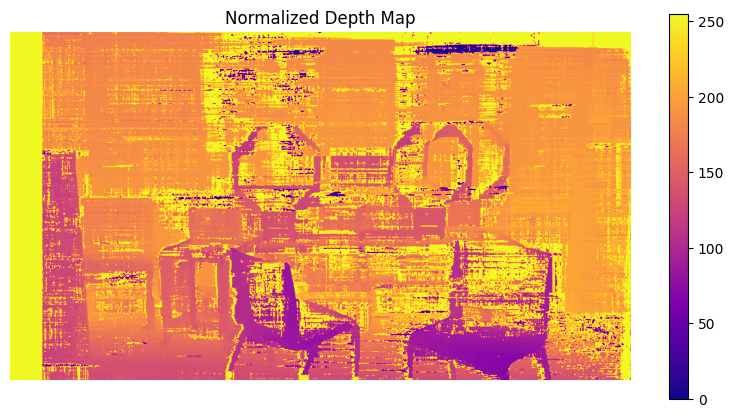

True

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the stereo images
image_left = cv2.imread('/content/drive/MyDrive/Bhavana/Perception/problem2_dataset/storageroom/im0.png', cv2.IMREAD_GRAYSCALE)
image_right = cv2.imread('/content/drive/MyDrive/Bhavana/Perception/problem2_dataset/storageroom/im1.png', cv2.IMREAD_GRAYSCALE)

# Intrinsic camera matrices for left and right camera from the new calibration data
camera_matrix_left = np.array([[1742.11, 0, 804.90],
                              [0, 1742.11, 541.22],
                              [0, 0, 1]])
camera_matrix_right = np.array([[1742.11, 0, 804.90],
                               [0, 1742.11, 541.22],
                               [0, 0, 1]])

# New calibration parameters
doffs = 0
baseline = 221.76
width = 1920
height = 1080
ndisp = 100
vmin = 29
vmax = 61

# StereoSGBM Parameters setup with the new calibration values
min_disparity = vmin
num_disparities = ndisp - min_disparity  # The search range for disparities
block_size = 3

# Initialize the stereo block matching object
stereo = cv2.StereoSGBM_create(
    minDisparity=min_disparity,
    numDisparities=num_disparities,
    blockSize=block_size,
    P1=8 * 3 * block_size ** 2,
    P2=32 * 3 * block_size ** 2,
    disp12MaxDiff=1,
    uniquenessRatio=15,
    speckleWindowSize=0,
    speckleRange=2,
    preFilterCap=63,
    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
)

# Compute the disparity map
disparity = stereo.compute(image_left, image_right).astype(np.float32) / 16.0

# Calculate the depth map using the formula: depth = baseline * focal_length / disparity
focal_length_pixel = camera_matrix_left[0, 0]  # The focal length in pixels

# Avoid division by zero in disparity to calculate depth
depth_map = np.zeros_like(disparity)
non_zero_disparity = disparity > 0
depth_map[non_zero_disparity] = (baseline * focal_length_pixel) / disparity[non_zero_disparity]

# Normalize the depth map for visualization
depth_map_visual = cv2.normalize(depth_map, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# Display the normalized depth map
plt.figure(figsize=(10, 5))
plt.imshow(depth_map_visual, cmap='plasma')
plt.colorbar()
plt.title('Normalized Depth Map')
plt.axis('off')
plt.show()

# Save the normalized depth map visual for download
depth_map_visual_filename = 'normalized_depth_map_visual.png'
cv2.imwrite(depth_map_visual_filename, depth_map_visual)


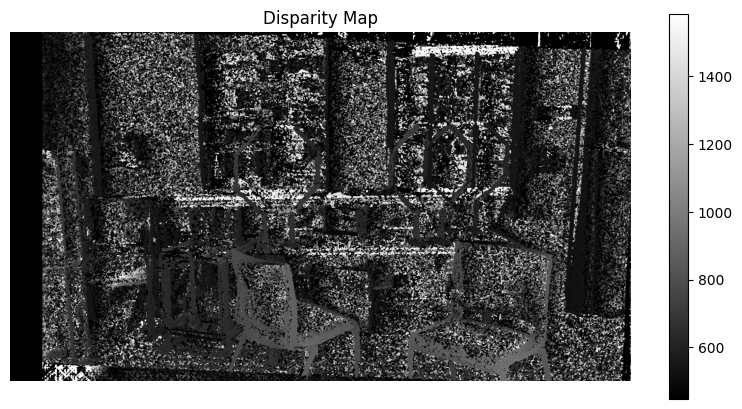

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the stereo images
image_left = cv2.imread('/content/drive/MyDrive/Bhavana/Perception/problem2_dataset/storageroom/im0.png', cv2.IMREAD_GRAYSCALE)
image_right = cv2.imread('/content/drive/MyDrive/Bhavana/Perception/problem2_dataset/storageroom/im1.png', cv2.IMREAD_GRAYSCALE)

# Intrinsic camera matrices for left and right camera
camera_matrix_left = np.array([[1742.11, 0, 804.90],
                              [0, 1742.11, 541.22],
                              [0, 0, 1]])
camera_matrix_right = np.array([[1742.11, 0, 804.90],
                               [0, 1742.11, 541.22],
                               [0, 0, 1]])

# StereoSGBM Parameters setup with provided calibration values
min_disparity = vmin
num_disparities = ndisp - min_disparity  # The search range for disparities
block_size = 5


# Initialize the stereo block matching object
stereo = cv2.StereoSGBM_create(
    minDisparity=min_disparity,
    numDisparities=num_disparities,
    blockSize=block_size
)

# Compute the disparity map
disparity = stereo.compute(image_left, image_right)

# Display the disparity map
plt.figure(figsize=(10, 5))
plt.imshow(disparity, cmap='gray')
plt.colorbar()
plt.title('Disparity Map')
plt.axis('off')
plt.show()
